## Import Statements

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dataclasses import dataclass
from IPython.core.debugger import set_trace
import pprint
from functools import lru_cache

import numpy as np
from numpy.random import default_rng
from numpy.linalg import inv, norm, det, solve, lstsq
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from specified import Specified_Model
from misspecified import Misspecified_Model
from utils import pshape

In [3]:
np.seterr('warn')
np.set_printoptions(precision=6)

## Managing Variables, Data, and Parameters

In [4]:
class Hyperparams(object):
    def __init__(self, n=10000, A=2, B=2, seed=9):
        self.n = n
        self.A = A
        self.B = B
        self.seed = seed
        
class Priors(object):
    def __init__(self, hparams):
        rng = default_rng(hparams.seed)

        self.t_mean = np.zeros(hparams.A)
        self.t_cov = np.eye(hparams.A)

        self.r_mean = np.zeros(hparams.B)
        self.r_cov = np.eye(hparams.B)

        self.nu_mean = rng.uniform(low=1, high=10, size=hparams.A)
        self.nu_cov = rng.uniform() * np.ones((hparams.A)) # only store diagonals of cov matrix

        self.gamma_mean = rng.uniform(low=1, high=10, size=hparams.B)
        self.gamma_cov = rng.uniform() * np.ones((hparams.B)) # only store diagonals of cov matrix

        # inverse of nu and gamma covariance matrices
        self.nu_icov = np.diag(inv(np.diag(self.nu_cov))) # only store diagonals of cov matrix
        self.gamma_icov = np.diag(inv(np.diag(self.gamma_cov))) # only store diagonals of cov matrix

        self.epsilon_mean = np.array(0.0)
        self.epsilon_var = rng.uniform()

class Params(object):
    def __init__(self, hparams, priors):
        rng = default_rng(hparams.seed)
 
        self.alpha = 1.

        self.nu = rng.multivariate_normal(priors.nu_mean, np.diag(priors.nu_cov)) # sample nu from multivariate normal w/ diagonal covar matrix
        self.gamma = rng.multivariate_normal(priors.gamma_mean, np.diag(priors.gamma_cov)) # sample gamma from multivariate normal w/ diagonal covar matrix
        assert(self.gamma.any() != 0) # Some element of gamma must not == 0, otherwise there's no misspecification

        self.t = rng.multivariate_normal(priors.t_mean, priors.t_cov, hparams.n) # sample t from multivariate normal density 
        self.r = rng.multivariate_normal(priors.r_mean, priors.r_cov, hparams.n) # sample r from multivariate normal density
        self.epsilon = rng.normal(priors.epsilon_mean, priors.epsilon_var, hparams.n) # Must be independent of t and x

        #  y = nu * t + gamma * r + epsilon
        self.y = np.matmul(self.nu[np.newaxis,:], np.transpose(self.t))
        self.y += np.matmul(self.gamma[np.newaxis,:], np.transpose(self.r))
        self.y += self.epsilon
        self.y = self.y.T 

## Finding Optimal Alpha Value

In [5]:
def calc_true_posterior(hparams, priors, params):
    tp_dict = {}

    # calculate true posterior for nu
    t1 = (params.t.T @ params.y) / (hparams.n * priors.epsilon_var)
    t1 += (priors.nu_mean / (hparams.n * priors.nu_cov[0]))[:, np.newaxis] # [a, 1]
    t2 = np.sum(params.t **2) / (hparams.n * priors.epsilon_var)
    t2 += np.eye(hparams.A) / (hparams.n * priors.nu_cov[0])
    t2_inv = inv(t2)

    tp_dict['nu_posterior_mean'] = t2_inv @ t1
    tp_dict['nu_posterior_cov'] = hparams.n * t2_inv

    # calc true posterior for gamma
    t3 = (params.r.T @ params.y) / (hparams.n * priors.epsilon_var)
    t3 += (priors.gamma_mean / (hparams.n * priors.gamma_cov[0]))[:, np.newaxis] # [b, 1]
    t4 = np.sum(params.r **2) / (hparams.n * priors.epsilon_var)
    t4 += np.eye(hparams.B) / (hparams.n * priors.gamma_cov[0])
    t4_inv = inv(t4)

    tp_dict['gamma_posterior_mean'] = t4_inv @ t3
    tp_dict['gamma_posterior_cov'] = hparams.n * t4_inv

    return tp_dict

def calc_kl_ms(ms_params, tp_dict):
    mean1 = ms_params[0]
    cov1 = np.diag(ms_params[1])
    mean2 = tp_dict['nu_posterior_mean']
    cov2 = tp_dict['nu_posterior_cov']

    cov2_inv = inv(cov2)
    t1 = np.log(det(cov2) / det(cov1))
    t2 = np.trace(cov2_inv @ cov1)
    t3 = (mean2 - mean1).T @ cov2_inv @ (mean2 - mean1)
    t4 = mean1.shape[0]
    ans = 0.5 * (t1 + t2 + t3 - t4)
    return ans.squeeze()

def calc_kl_s(s_params, tp_dict):
    mean1 = s_params[0]
    cov1 = np.diag(s_params[1])
    mean2 = tp_dict['nu_posterior_mean']
    cov2 = tp_dict['nu_posterior_cov']

    cov2_inv = inv(cov2)
    t1 = np.log(det(cov2) / det(cov1))
    t2 = np.trace(cov2_inv @ cov1)
    t3 = (mean2 - mean1).T @ cov2_inv @ (mean2 - mean1)
    t4 = mean1.shape[0]
    ans = 0.5 * (t1 + t2 + t3 - t4)
    return ans.squeeze()

#def calc_kl_s(s_params, tp_dict):
#    mean1 = np.vstack((s_params[0], s_params[2]))
#    t1 = np.diag(s_params[1])[:, np.newaxis]
#    t2 = np.diag(s_params[3])[:, np.newaxis]
#    cov1 = np.diag(np.vstack((t1, t2)).squeeze())
#    mean2 = np.vstack((tp_dict['nu_posterior_mean'], 
#                        tp_dict['gamma_posterior_mean']))
#    t3 = np.diag(tp_dict['nu_posterior_cov'])[:, np.newaxis]
#    t4 = np.diag(tp_dict['gamma_posterior_cov'])[:, np.newaxis]
#    cov2 = np.diag(np.vstack((t3, t4)).squeeze())
#
#    cov2_inv = inv(cov2)
#    t1 = np.log(det(cov2) / det(cov1))
#    t2 = np.trace(cov2_inv @ cov1)
#    t3 = (mean2 - mean1).T @ cov2_inv @ (mean2 - mean1)
#    t4 = mean1.shape[0]
#    ans = 0.5 * (t1 + t2 + t3 - t4)
#    return ans.squeeze()

def graph_kl(kl_result, specified=False, misspecified=False, expected=True):
    '''
    kl_result is an [alpha_num x 3] numpy array
    1st column = expected kl, 2nd column = kl_s, 3rd column = kl_ms
    '''
    alpha_num = kl_result.shape[0]
    alpha = np.linspace(0,1, alpha_num)

    if specified:
        plt.plot(alpha, np.sort(kl_result[:,1]), label='Specified KL')
    if misspecified:
        plt.plot(alpha, np.sort(kl_result[:,2]), label='Misspecified KL')
    if expected:
        plt.plot(alpha, np.sort(kl_result[:,0]), label='Expected KL')
    plt.xlabel('Alpha')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence W/ Diff Alpha Values')
    plt.grid(True)
    plt.savefig('plots/Alpha_KL_Divergence.png')
    plt.legend()
    plt.show()

def graph_mse(mse_result):
    '''
    ms_result is an [alpha_num x 2] numpy array
    1st column = mean squared error between true nu and approx nu for specified variational approximation,
    2nd column = mean squared error between true nu and approx nu for misspecified variational approximation'''
    alpha_num = mse_result.shape[0]
    alpha = np.linspace(0,1, alpha_num)

    plt.plot(alpha, np.sort(mse_result[:,0]), label=['Specified Nu MSE'])
    plt.plot(alpha, np.sort(mse_result[:,1]), label=['Misspecified Nu MSE'])
    plt.xlabel('Alpha')
    plt.ylabel('Nu MSE')
    plt.title('Nu MSE  W/ Diff Alpha Values')
    plt.grid(True)
    plt.savefig('plots/Alpha_Nu_MSE.png')
    plt.show()

def graph_mse2(mse_result):
    '''
    ms_result is an [alpha_num x 2] numpy array
    1st column = mean squared error between true nu and approx nu for specified variational approximation,
    2nd column = mean squared error between true nu and approx nu for misspecified variational approximation'''
    alpha_num = mse_result.shape[0]
    alpha = np.linspace(0,1, alpha_num)

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Nu Specified MSE', color=color)
    ax1.plot(alpha, np.sort(mse_result[:,0]), color=color, label=['Specified Nu MSE'])

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Nu Misspecified MSE', color=color)
    ax2.plot(alpha, np.sort(mse_result[:,1]), color=color, label=['Misspecified Nu MSE'])
  
    fig.suptitle('Nu MSE  W/ Diff Alpha Values')
    fig.savefig('plots/Alpha_Nu_MSE.png')

def graph_mse_specified(mse_dict):
    lists = sorted(mse_dict.items()) # sorted by key, return a list of tuples
    alpha, mse_val = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(alpha, mse_val)
    plt.xlabel('Alpha')
    plt.ylabel('Nu MSE')
    plt.title('Nu MSE  W/ Diff Alpha Values')
    plt.grid(True)
    plt.savefig('plots/Alpha_Nu_MSE.png')
    plt.show()

In [13]:
def main():
    # hyper-parameters and initialization
    alpha_num = 15
    p = 0.5 # probability of misspecifed model occuring
    kl_result = np.zeros((alpha_num,3))
    mse_result = np.zeros((alpha_num, 2))
    mse_specified = {}

    # generate hyper-parameters, priors, and parameters
    hparams = Hyperparams(n=500)
    priors = Priors(hparams)
    params = Params(hparams, priors)

    # generate true posterior
    tp_params = calc_true_posterior(hparams, priors, params)

    for counter, alpha in enumerate(np.linspace(0, 1, alpha_num)):
        params.alpha = alpha # set alpha value

        # generate variational approximation to specified model
        s = Specified_Model(hparams, priors, params)
        s.fit(printing=False)
        s_params = [s.aprx_nu_mean[:, np.newaxis], s.aprx_nu_cov,
                    s.aprx_gamma_mean[:, np.newaxis], s.aprx_gamma_cov]

        # generate variational approximation to misspecified model
        ms = Misspecified_Model(hparams, priors, params)
        ms.fit(printing=False)
        ms_params = [ms.aprx_nu_mean[:, np.newaxis], ms.aprx_nu_cov]

        # calc kl divergence
        kl_ms = calc_kl_ms(ms_params, tp_params)
        kl_s = calc_kl_s(s_params, tp_params)

        # add stats to dict
        kl_exp = (kl_s * (1-p)) + (kl_ms * p) # expected kl divergence
        kl_result[counter,:] = np.array([kl_exp, kl_s, kl_ms])
        mse_result[counter,:] = np.array([s.get_nu_mse(), ms.get_nu_mse()])
        mse_specified[alpha] = ms.get_nu_mse()

    graph_kl(kl_result, specified=True, misspecified=True) # graph kl divergence
    graph_mse2(mse_result) # graph nu mse from speicfied and unspecified models

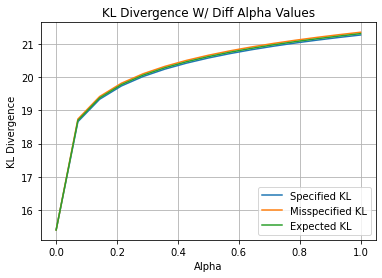

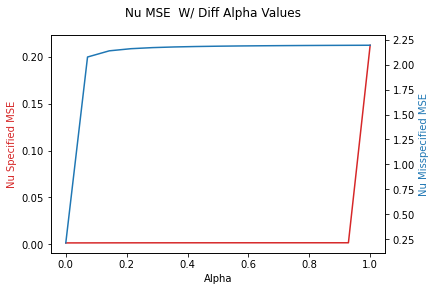

In [14]:
main()

### When $\alpha=0$, the specified KL divergence and the misspecified KL divergence are exactly the same. This is because when $\alpha=0$, the mean and covariance for variational approximations (VAs) for specified and misspecified models are exactly the same. Why is this? Furthermore, VA of specified and misspecified models should def have different covariances since they are intialized once then never changed. However, they are actually set to the same (constant) value regardless of covariance initilization

### Now it appears that also regardless of initialization, the mean always becomes a constant factor when alpha=0

## CAVI Algo vs Linear Regression (Least Squares)

In [8]:
hparams = Hyperparams(n=1000)
priors = Priors(hparams)
params = Params(hparams, priors)
params.alpha = 0.3
print('Actual Means:\t\t\t\t', np.hstack((params.nu, params.gamma)))

# CAVI algorithm (Specified)
s = Specified_Model(hparams, priors, params)
s.fit(printing=False)
#s.plot_elbo()
print('Variational Approximation Means:\t', np.hstack((s.aprx_nu_mean, s.aprx_gamma_mean)))

# KL Divergence (Specified)
s_params = [s.aprx_nu_mean[:, np.newaxis], np.diag(s.aprx_nu_cov),
                    s.aprx_gamma_mean[:, np.newaxis], np.diag(s.aprx_gamma_cov)]
tp_dict = calc_true_posterior(hparams, priors, params)
kl = calc_kl_s(s_params, tp_dict)
#print('KL:\t\t\t\t\t', kl)

# Solve Linear Equation
a = np.hstack([params.t.squeeze(), params.r.squeeze()])
b = params.y
x, _, _, _ = lstsq(a, b)
print('Least Squares Means:\t\t\t', x.T.squeeze())


Actual Means:				 [8.208739 3.769958 6.41309  8.072403]
Variational Approximation Means:	 [8.191799 3.738004 6.410549 8.094665]


LinAlgError: 1-dimensional array given. Array must be at least two-dimensional